[*********************100%***********************]  3 of 3 completed



去庫存化率: 2
風險投組權重 (風險資產): 150.00%
無風險資產權重: -50.00%

最大夏普比率投組權重 (調整後):
2330.TW: 76.92%
2317.TW: 0.00%
2454.TW: 23.08%


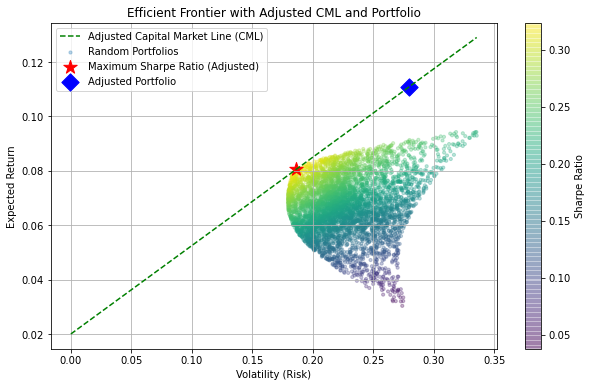

In [56]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 設定台股股票代碼
tickers = ['2330.TW', '2317.TW', '2454.TW']  # 可自行添加更多股票代碼
start_date = '2022-01-01'
end_date = '2023-12-31'

# 下載股價資料
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
returns = data.pct_change().dropna()

# 設定無風險利率與初始去庫存化率 (假設值，可替換為真實數據)
risk_free_rate = 0.02
de_inventory_rate = 2  # 假設去庫存化率（>1 表示高，<1 表示低）

# 調整資產配置比例
def adjust_allocation_by_deinventory(de_inventory_rate):
    if de_inventory_rate > 1:
        return 1 + (de_inventory_rate - 1) * 0.5  # 去庫存化率高時，風險資產比例放大
    else:
        return 1 - (1 - de_inventory_rate) * 0.5  # 去庫存化率低時，風險資產比例縮小

allocation_multiplier = adjust_allocation_by_deinventory(de_inventory_rate)

# 投資組合表現計算函數
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate):
    weights = np.array(weights)
    returns = np.sum(mean_returns * weights) * 252  # 年化回報
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))  # 年化波動率
    sharpe_ratio = (returns - risk_free_rate) / volatility
    return returns, volatility, sharpe_ratio

# 最大夏普比率投組的優化
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # 權重總和為 1
    bounds = tuple((0, 1) for _ in range(num_assets))  # 權重限制在 [0, 1]
    result = minimize(lambda x: -portfolio_performance(x, *args)[2],  # 最大化夏普比率 (最小化負值)
                      x0=[1./num_assets]*num_assets,
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)
    return result

# 隨機生成投資組合，模擬效率前緣
def simulate_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))  # 儲存回報率、波動率、夏普比率
    weights_record = []
    
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)  # 確保權重總和為 1
        weights_record.append(weights)
        
        portfolio_return, portfolio_volatility, portfolio_sharpe = portfolio_performance(
            weights, mean_returns, cov_matrix, risk_free_rate)
        results[0, i] = portfolio_return
        results[1, i] = portfolio_volatility
        results[2, i] = portfolio_sharpe
    
    return results, weights_record

# 計算結果
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 5000

# 模擬效率前緣
results, weights_record = simulate_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)
max_sharpe_result = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)

# 調整最大夏普比率投組
risk_portfolio_weight = allocation_multiplier
risk_free_weight = 1 - allocation_multiplier

max_sharpe_weights = max_sharpe_result.x * risk_portfolio_weight  # 調整風險資產配置
max_sharpe_weights /= max_sharpe_weights.sum()  # 確保總和為 1

max_sharpe_ret, max_sharpe_vol, max_sharpe_sr = portfolio_performance(max_sharpe_weights, mean_returns, cov_matrix, risk_free_rate)

# 打印權重與配置比例
print(f"\n去庫存化率: {de_inventory_rate}")
print(f"風險投組權重 (風險資產): {risk_portfolio_weight:.2%}")
print(f"無風險資產權重: {risk_free_weight:.2%}")

print("\n最大夏普比率投組權重 (調整後):")
for ticker, weight in zip(tickers, max_sharpe_weights):
    print(f"{ticker}: {weight:.2%}")

# 繪製效率前緣與調整後 CML
plt.figure(figsize=(10, 6))

# 隨機投資組合
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o', s=10, alpha=0.3, label='Random Portfolios')
plt.colorbar(label='Sharpe Ratio')

# 效率前緣與 CML
cml_x = np.linspace(0, max(results[1, :]), 100)  # 生成 x 軸的波動率數據
cml_y = risk_free_rate + max_sharpe_sr * cml_x  # 調整後 CML 公式
plt.plot(cml_x, cml_y, color='green', linestyle='--', label='Adjusted Capital Market Line (CML)')

# 標記最大夏普比率投組
plt.scatter(max_sharpe_vol, max_sharpe_ret, color='red', marker='*', s=200, label='Maximum Sharpe Ratio (Adjusted)')

# 標記調整後投組
adjusted_ret = max_sharpe_ret * risk_portfolio_weight + risk_free_rate * risk_free_weight
adjusted_vol = max_sharpe_vol * risk_portfolio_weight
plt.scatter(adjusted_vol, adjusted_ret, color='blue', marker='D', s=150, label='Adjusted Portfolio')

plt.title('Efficient Frontier with Adjusted CML and Portfolio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid()
plt.show()
